# STATISTICAL LEARNING PROJECT:

In [125]:
# Librerie base
import numpy as np
import pandas as pd

# Visualizzazione
import matplotlib.pyplot as plt  
import seaborn as sns

# Modelli statistici
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

# Libreria ISLP (Statistical Learning)
from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)


In [126]:
# carico il dataset e stampo l'head
df = pd.read_csv("f1_pitstops_2018_2024.csv", encoding='utf-8')
df.head()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,Race Name,...,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score,Abbreviation,Stint,Tire Compound,Stint Length,Pit_Lap,Pit_Time
0,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,1.0,ULTRASOFT,25.0,26.0,21.787
1,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,2.0,SOFT,32.0,NaN,Final Stint
2,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,1.0,ULTRASOFT,17.0,19.0,21.821
3,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,2.0,SOFT,39.0,NaN,Final Stint
4,2018,1,Albert Park Grand Prix Circuit,Kimi RÃƒÂ¤ikkÃƒÂ¶nen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,0.017241,45.13482,0.086957,6.818562,RAI,1.0,ULTRASOFT,17.0,18.0,21.421


In [127]:
print("Colonne:\n\n")
df.columns

Colonne:




Index(['Season', 'Round', 'Circuit', 'Driver', 'Constructor', 'Laps',
       'Position', 'TotalPitStops', 'AvgPitStopTime', 'Race Name', 'Date',
       'Time_of_race', 'Location', 'Country', 'Air_Temp_C', 'Track_Temp_C',
       'Humidity_%', 'Wind_Speed_KMH', 'Lap Time Variation', 'Total Pit Stops',
       'Tire Usage Aggression', 'Fast Lap Attempts', 'Position Changes',
       'Driver Aggression Score', 'Abbreviation', 'Stint', 'Tire Compound',
       'Stint Length', 'Pit_Lap', 'Pit_Time'],
      dtype='object')

In [128]:
print("Informazioni:\n\n")

df.info()

Informazioni:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time_of_race             7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air_Temp

In [129]:
print("Statistiche descrittive:\n\n")
print(df.describe())

Statistiche descrittive:


            Season        Round         Laps     Position  TotalPitStops  \
count  7374.000000  7374.000000  7374.000000  7374.000000    7374.000000   
mean   2021.308245    10.673312    56.643748    10.156089       2.068348   
std       1.969604     6.135126    13.922667     5.590062       1.135088   
min    2018.000000     1.000000     0.000000     1.000000       0.000000   
25%    2020.000000     5.000000    52.000000     5.000000       1.000000   
50%    2021.000000    11.000000    57.000000    10.000000       2.000000   
75%    2023.000000    15.000000    66.000000    15.000000       3.000000   
max    2024.000000    24.000000    87.000000    20.000000       7.000000   

       AvgPitStopTime   Air_Temp_C  Track_Temp_C   Humidity_%  Wind_Speed_KMH  \
count     7189.000000  7001.000000   7001.000000  7001.000000     7001.000000   
mean       120.109095    19.520345     25.207104    67.576191       11.434032   
std        268.723688     5.092982      5.195

## Check if the data contains any missing values

In [130]:
# Controllo i dati nulli
columnsWithNulls=df.isnull().sum().sort_values(ascending=False)
columnsWithNulls=columnsWithNulls[columnsWithNulls>0]
print(columnsWithNulls)

Pit_Lap                    2810
Track_Temp_C                373
Date                        373
Wind_Speed_KMH              373
Humidity_%                  373
Air_Temp_C                  373
Country                     373
Location                    373
Time_of_race                373
Race Name                   373
Pit_Time                    281
AvgPitStopTime              185
Lap Time Variation          185
Driver Aggression Score     185
Fast Lap Attempts           185
Stint Length                109
Tire Compound               109
Stint                       109
Tire Usage Aggression        66
dtype: int64


Pit_Lap                    38.106862
Wind_Speed_KMH              5.058313
Date                        5.058313
Time_of_race                5.058313
Location                    5.058313
Country                     5.058313
Air_Temp_C                  5.058313
Track_Temp_C                5.058313
Humidity_%                  5.058313
Race Name                   5.058313
Pit_Time                    3.810686
Fast Lap Attempts           2.508815
Driver Aggression Score     2.508815
Lap Time Variation          2.508815
AvgPitStopTime              2.508815
Stint                       1.478167
Tire Compound               1.478167
Stint Length                1.478167
Tire Usage Aggression       0.895037
dtype: float64


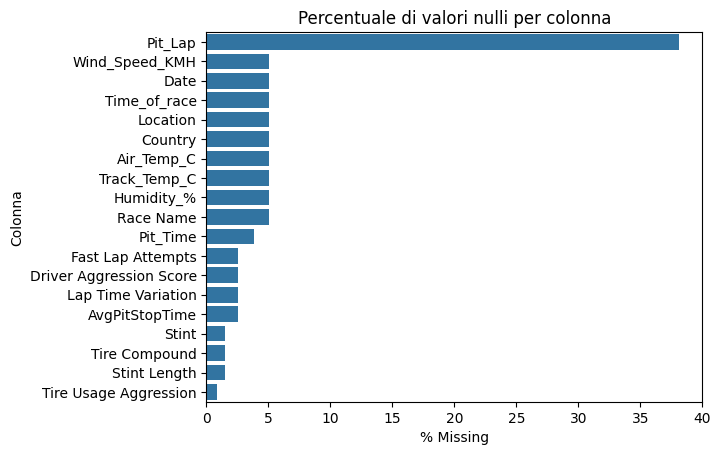

In [131]:
# Controllo in percentuale quanti dati mancano così da capire come trattarli, pongo una soglia di eliminazione del regressore nel caso di +30% di dati mancanti
missing_pct = df.isnull().mean() * 100
missing_only = missing_pct[missing_pct > 0].sort_values(ascending=False)
print(missing_only)
sns.barplot(x=missing_only.values, y=missing_only.index)
plt.title('Percentuale di valori nulli per colonna')
plt.xlabel('% Missing')
plt.ylabel('Colonna')
plt.show()

In [132]:
#droppiamo le righe con i valori nulli e le colonne con più del 30% di dati nulli
df.dropna(axis=0, inplace=True)
df.drop(columns=missing_only[missing_only>30].index, inplace=True)
df.isnull().sum()



Season                     0
Round                      0
Circuit                    0
Driver                     0
Constructor                0
Laps                       0
Position                   0
TotalPitStops              0
AvgPitStopTime             0
Race Name                  0
Date                       0
Time_of_race               0
Location                   0
Country                    0
Air_Temp_C                 0
Track_Temp_C               0
Humidity_%                 0
Wind_Speed_KMH             0
Lap Time Variation         0
Total Pit Stops            0
Tire Usage Aggression      0
Fast Lap Attempts          0
Position Changes           0
Driver Aggression Score    0
Abbreviation               0
Stint                      0
Tire Compound              0
Stint Length               0
Pit_Time                   0
dtype: int64

## Data Preprocessing

## Correlation HeatMap 

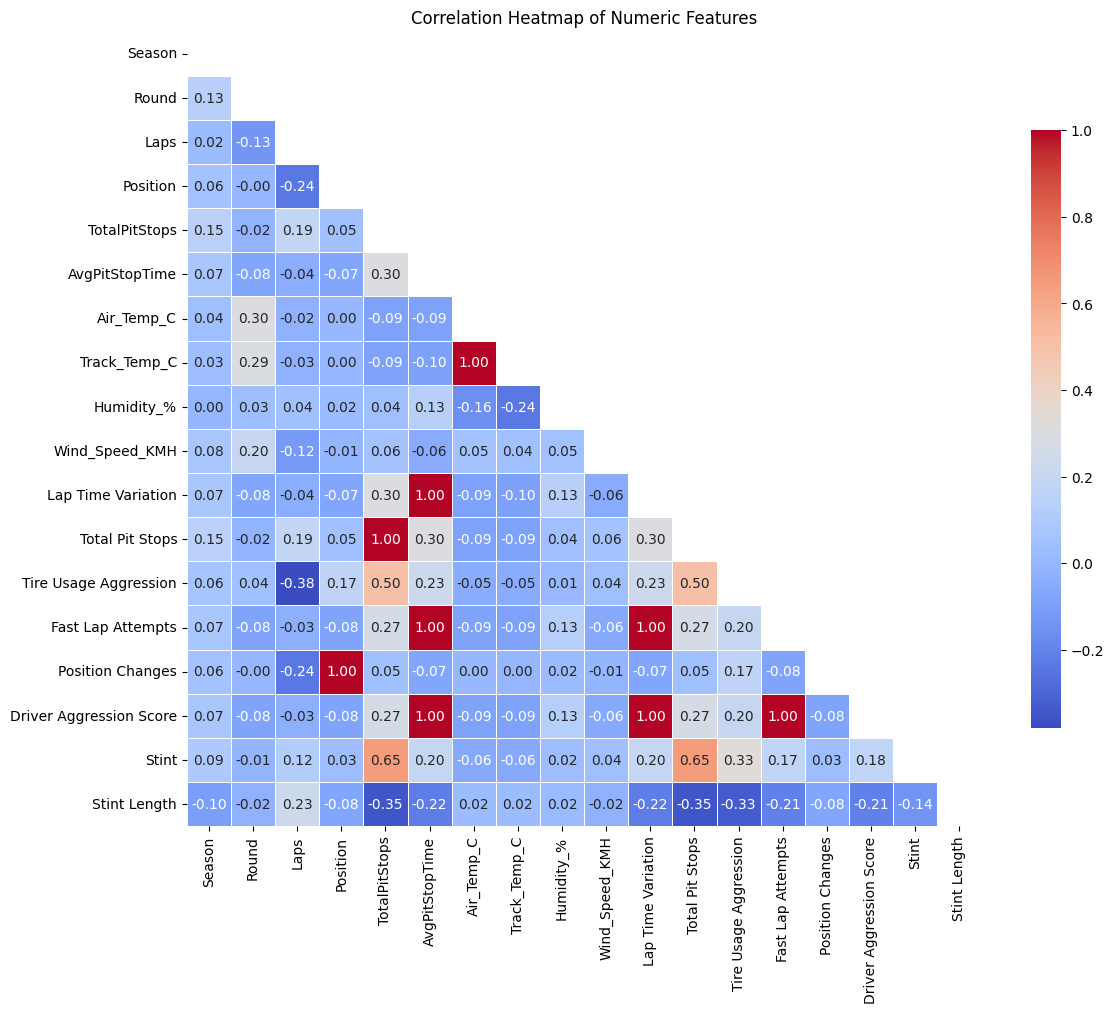

In [133]:
# Seleziona le colonne numeriche
numeric_df = df.select_dtypes(include=[np.number])

# Controllo che ci siano almeno 4 variabili numeriche per evitare visualizzazioni poco utili
if numeric_df.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_df.corr()
    
    # Crea una maschera triangolare superiore per evitare ridondanza
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Imposta la figura
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')


In [134]:
# 1. Seleziona solo le colonne numeriche e calcola la correlazione assoluta
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr().abs()

# 2. Prendi la metà superiore (senza diagonale)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# 3. Trova tutte le colonne con correlazione > 0.99
to_drop = upper.columns[upper.gt(0.99).any()].tolist()
print("Tutte le colonne candidate al drop:", to_drop)

# 4. Rimuovi 'Driver Aggression Score' dalla lista, se presente
to_drop = [col for col in to_drop if col != "Driver Aggression Score"]
print("Colonne da droppare (escl. Driver Aggression Score):", to_drop)

# 5. Droppa le colonne selezionate (incluse quelle con > 0.99)
df.drop(columns=to_drop, inplace=True)

# 6. Droppa anche AvgPitStopTime
df.drop(columns=['AvgPitStopTime'], inplace=True)

Tutte le colonne candidate al drop: ['Track_Temp_C', 'Lap Time Variation', 'Total Pit Stops', 'Fast Lap Attempts', 'Position Changes', 'Driver Aggression Score']
Colonne da droppare (escl. Driver Aggression Score): ['Track_Temp_C', 'Lap Time Variation', 'Total Pit Stops', 'Fast Lap Attempts', 'Position Changes']


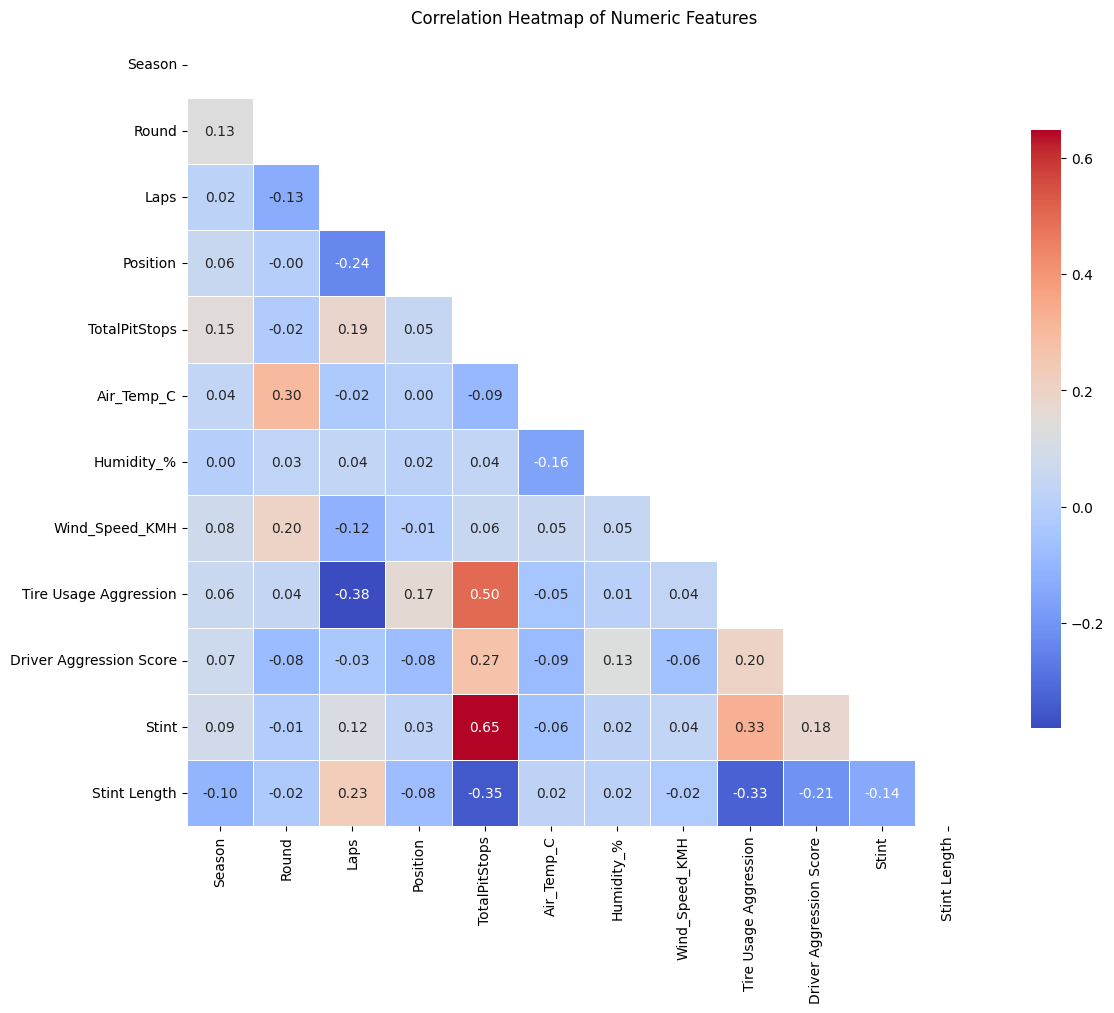

In [135]:
# Seleziona le colonne numeriche
numeric_df = df.select_dtypes(include=[np.number])

# Controllo che ci siano almeno 4 variabili numeriche per evitare visualizzazioni poco utili
if numeric_df.shape[1] >= 4:
    # Calcola la matrice di correlazione
    corr = numeric_df.corr()
    
    # Crea una maschera triangolare superiore per evitare ridondanza
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Imposta la figura
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .75}
    )
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap')


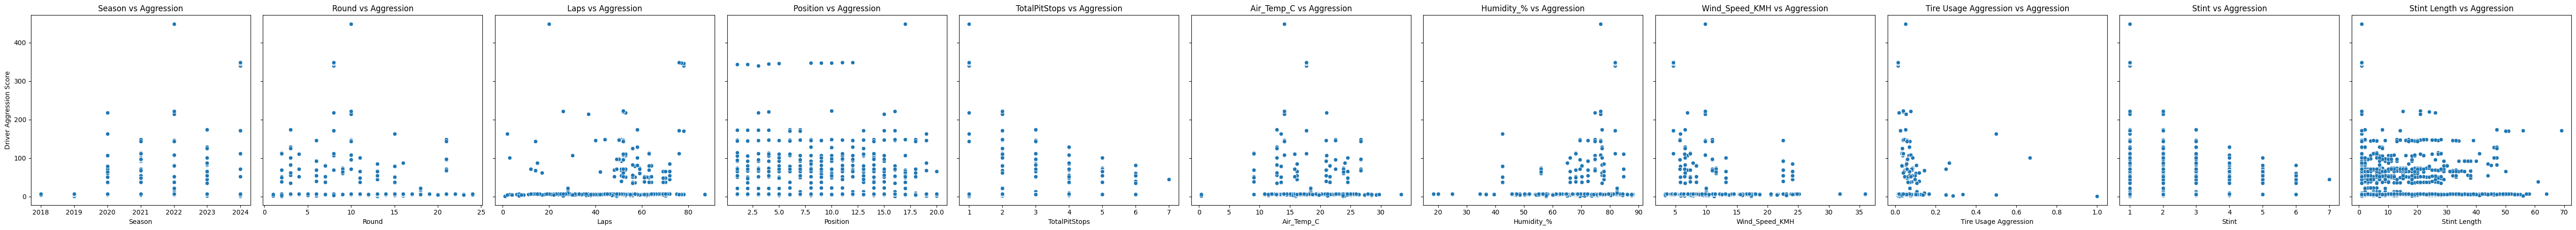

In [136]:
# Seleziona solo le variabili numeriche tranne 'Driver Aggression Score'
numeric_cols = df.select_dtypes(include='number').columns
x_vars = [col for col in numeric_cols if col != 'Driver Aggression Score']

# Controlla se ci sono abbastanza variabili da visualizzare
n = len(x_vars)
if n > 0:
    # Imposta il layout della figura
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)

    # Scatterplot di ogni variabile rispetto al Driver Aggression Score
    for i, var in enumerate(x_vars):
        sns.scatterplot(data=df, x=var, y='Driver Aggression Score', ax=axes[i])
        axes[i].set_title(f'{var} vs Aggression')
        axes[i].set_xlabel(var)

    axes[0].set_ylabel('Driver Aggression Score')
    plt.tight_layout()
    plt.show()
else:
    print('Nessuna variabile numerica disponibile per il confronto con Driver Aggression Score')

## TEST MODELLO LINEARE

In [137]:
# Verifica che la colonna 'TotalPitStops' sia presente nel dataframe
if 'TotalPitStops' in df.columns:
    # Creazione del dataframe X con intercetta e la variabile indipendente 'TotalPitStops'
    X = pd.DataFrame({
        'intercept': np.ones(df.shape[0]),  # Colonna di 1 per l'intercetta
        'TotalPitStops': df['TotalPitStops'],  # Feature indipendente
    })
    # Visualizza i primi 4 record di X
    print(X.head(4))
else:
    print("'TotalPitStops' non è presente nel dataframe.")

   intercept  TotalPitStops
0        1.0              1
2        1.0              1
4        1.0              1
6        1.0              1


In [138]:
# Verifica che la variabile target 'Driver Aggression Score' sia presente nel dataframe
if 'Driver Aggression Score' in df.columns:
    y = df['Driver Aggression Score']  # La variabile target
    # Verifica che il numero di osservazioni sia maggiore del numero di variabili
    if X.shape[0] > X.shape[1]:
        # Definiamo il modello OLS
        model = sm.OLS(y, X)  # Funzione per adattare una regressione lineare semplice
        results = model.fit()  # Adattiamo il modello

        # Mostriamo un riassunto dei risultati
        print(results.summary())
    else:
        print("Il numero di osservazioni è troppo basso rispetto al numero di variabili per un modello affidabile.")
else:
    print("'Driver Aggression Score' non è presente nel dataframe.")

                               OLS Regression Results                              
Dep. Variable:     Driver Aggression Score   R-squared:                       0.072
Model:                                 OLS   Adj. R-squared:                  0.071
Method:                      Least Squares   F-statistic:                     334.5
Date:                     Tue, 22 Apr 2025   Prob (F-statistic):           4.86e-72
Time:                             13:44:52   Log-Likelihood:                -21680.
No. Observations:                     4334   AIC:                         4.336e+04
Df Residuals:                         4332   BIC:                         4.338e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [139]:
summarize(results) #produces a simple table of the parameter estimates, their standard errors, t-statistics and p-values

,coef,std err,t,P>|t|
intercept,0.4541,1.217,0.373,0.709
TotalPitStops,8.6129,0.471,18.289,0.000


                               OLS Regression Results                              
Dep. Variable:     Driver Aggression Score   R-squared:                       0.051
Model:                                 OLS   Adj. R-squared:                  0.050
Method:                      Least Squares   F-statistic:                     33.35
Date:                     Tue, 22 Apr 2025   Prob (F-statistic):           1.67e-45
Time:                             13:44:52   Log-Likelihood:                -21727.
No. Observations:                     4334   AIC:                         4.347e+04
Df Residuals:                         4326   BIC:                         4.352e+04
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

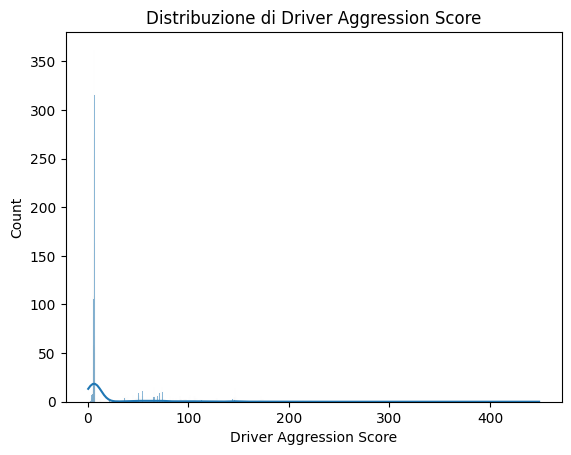

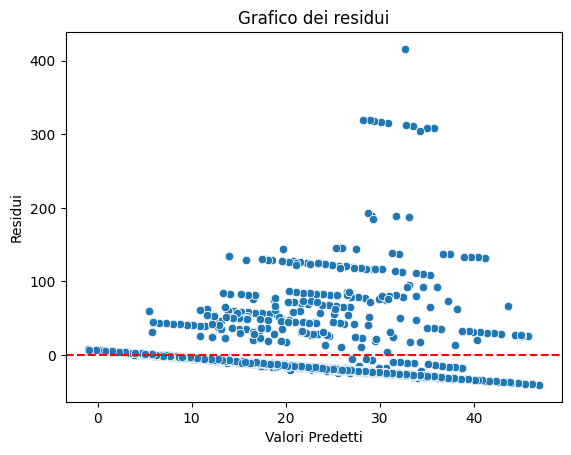

In [140]:
from sklearn.preprocessing import StandardScaler

# 1. Seleziona le colonne numeriche (senza 'Driver Aggression Score')
numeric_cols = ['Season', 'Round', 'Laps', 'Position', 'Air_Temp_C', 'Humidity_%', 'Wind_Speed_KMH']

X_numeric = df[numeric_cols]

# 2. Normalizza le variabili numeriche usando StandardScaler
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# 3. Aggiungi la colonna dell'intercetta (bias)
X_numeric_scaled = sm.add_constant(X_numeric_scaled)

# 4. Definisci la variabile target
y = df['Driver Aggression Score']

# 5. Crea e adatta il modello
model = sm.OLS(y, X_numeric_scaled)
results = model.fit()

# 6. Stampa un riepilogo
print(results.summary())

# 7. Verifica la collinearità (VIF - Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcola il VIF per ogni variabile
vif_data = pd.DataFrame()
vif_data["Variable"] = ['const'] + numeric_cols  # Aggiungi 'const' per l'intercetta
vif_data["VIF"] = [variance_inflation_factor(X_numeric_scaled, i) for i in range(X_numeric_scaled.shape[1])]

# Stampa il VIF per ogni variabile
print("\nVIF per ogni variabile:")
print(vif_data)

# 8. Controllo della distribuzione della variabile target (istogramma)
sns.histplot(y, kde=True)
plt.title('Distribuzione di Driver Aggression Score')
plt.show()

# 9. Verifica dei residui: grafico dei residui
residuals = results.resid
sns.scatterplot(x=results.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Grafico dei residui')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.show()

# Interpretazione

noto la distribuzione tutta schiacciata, provo a migliorala

l'analisi dei residui mostra che il modello lineare è troppo semplice per questo dataset

I valori VIF ottenuti sono abbastanza bassi (intorno all'1) non ho correlazione tra le variabli e posso considerarle indipendenti

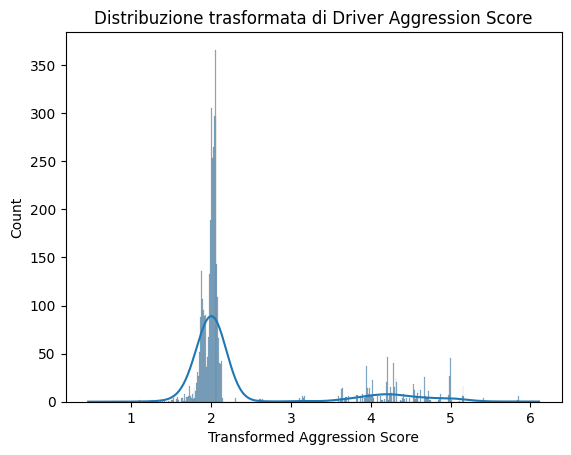

In [141]:
df['Transformed Aggression Score'] = np.log1p(df['Driver Aggression Score'])  # log(x + 1)
sns.histplot(df['Transformed Aggression Score'], kde=True)
plt.title('Distribuzione trasformata di Driver Aggression Score')
plt.show()

                                 OLS Regression Results                                 
Dep. Variable:     Transformed Aggression Score   R-squared:                       0.044
Model:                                      OLS   Adj. R-squared:                  0.042
Method:                           Least Squares   F-statistic:                     28.28
Date:                          Tue, 22 Apr 2025   Prob (F-statistic):           2.50e-38
Time:                                  13:45:00   Log-Likelihood:                -5689.3
No. Observations:                          4334   AIC:                         1.139e+04
Df Residuals:                              4326   BIC:                         1.145e+04
Df Model:                                     7                                         
Covariance Type:                      nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

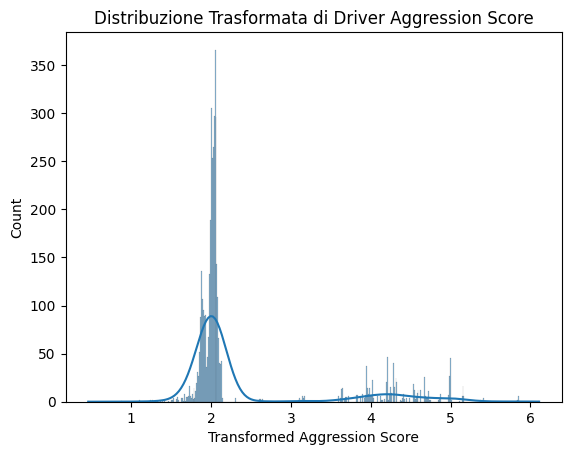

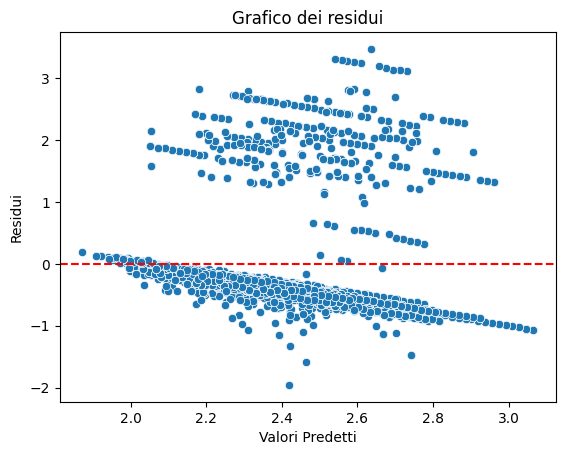

In [142]:
# 1. Seleziona le colonne numeriche (senza 'Transformed Aggression Score')
numeric_cols = ['Season','Round','Laps','Position','Air_Temp_C','Humidity_%','Wind_Speed_KMH']

X_numeric = df[numeric_cols]

# 2. Aggiungi la colonna dell'intercetta (bias)
X_numeric = sm.add_constant(X_numeric)

# 3. Definisci la nuova variabile target trasformata
y_transformed = df['Transformed Aggression Score']

# 4. Crea e adatta il modello con la variabile target trasformata
model = sm.OLS(y_transformed, X_numeric)
results = model.fit()

# 5. Stampa un riepilogo
print(results.summary())

# 6. Verifica la collinearità (VIF - Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcola il VIF per ogni variabile
vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# Stampa il VIF per ogni variabile
print("\nVIF per ogni variabile:")
print(vif_data)

# 7. Controllo della distribuzione della variabile target trasformata (istogramma)
sns.histplot(y_transformed, kde=True)
plt.title('Distribuzione Trasformata di Driver Aggression Score')
plt.show()

# 8. Verifica dei residui: grafico dei residui
residuals = results.resid
sns.scatterplot(x=results.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Grafico dei residui')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.show()

In [ ]:
# Raggruppo le ore per evitare overfitting
df['Hour'] = pd.to_datetime(df['Time_of_race'].str.replace('Z', ''), format='%H:%M:%S').dt.hour

# Creo colonne combinate utili aumentando il rischio di overfit

df['Constructor_Tire'] = df['Constructor'] + ' × ' + df['Tire Compound']
df['Location_Time'] = df['Location'] + ' × ' + df['Hour'].astype(str)
df['Temp_Humidity'] = df['Air_Temp_C'] * df['Humidity_%']

# Controllo il numero di correlazioni che creo, se sono troppo poche sto solo mettendo rumore!
print(df['Constructor_Tire'].nunique()) #105
print(df['Location_Time'].nunique()) #30

# Sono parecchie, così facendo sto quindi aumentando la dimensionalità del modello, dovrò filtrare solo per le correlazioni più frequenti e metto a "Other" le rimanenti

common_constr_tire = df['Constructor_Tire'].value_counts()[df['Constructor_Tire'].value_counts() >= 10].index
df['Constructor_Tire'] = df['Constructor_Tire'].where(df['Constructor_Tire'].isin(common_constr_tire), 'Other')

common_loc_time = df['Location_Time'].value_counts()[df['Location_Time'].value_counts() >= 10].index
df['Location_Time'] = df['Location_Time'].where(df['Location_Time'].isin(common_loc_time), 'Other')

print("\nNuovi valori:")
print(df['Constructor_Tire'].nunique()) #105
print(df['Location_Time'].nunique()) #30


105
30

Nuovi valori:
67
30


                                 OLS Regression Results                                 
Dep. Variable:     Transformed Aggression Score   R-squared:                       0.025
Model:                                      OLS   Adj. R-squared:                  0.024
Method:                           Least Squares   F-statistic:                     18.75
Date:                          Tue, 22 Apr 2025   Prob (F-statistic):           1.20e-21
Time:                                  13:45:01   Log-Likelihood:                -5730.6
No. Observations:                          4334   AIC:                         1.148e+04
Df Residuals:                              4327   BIC:                         1.152e+04
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

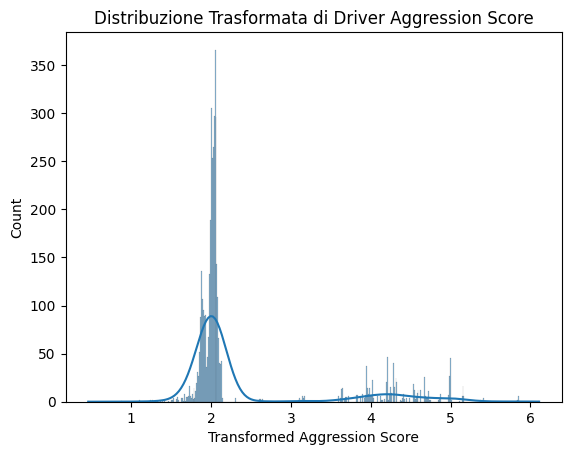

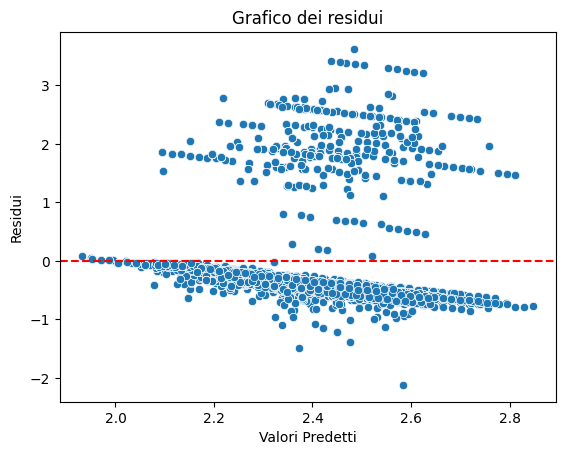

In [144]:
# 1. Seleziona le colonne numeriche (senza 'Transformed Aggression Score')
numeric_cols = ['Season','Round','Laps','Position','Wind_Speed_KMH','Temp_Humidity']

X_numeric = df[numeric_cols]

# 2. Aggiungi la colonna dell'intercetta (bias)
X_numeric = sm.add_constant(X_numeric)

# 3. Definisci la nuova variabile target trasformata
y_transformed = df['Transformed Aggression Score']

# 4. Crea e adatta il modello con la variabile target trasformata
model = sm.OLS(y_transformed, X_numeric)
results = model.fit()

# 5. Stampa un riepilogo
print(results.summary())

# 6. Verifica la collinearità (VIF - Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcola il VIF per ogni variabile
vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# Stampa il VIF per ogni variabile
print("\nVIF per ogni variabile:")
print(vif_data)

# 7. Controllo della distribuzione della variabile target trasformata (istogramma)
sns.histplot(y_transformed, kde=True)
plt.title('Distribuzione Trasformata di Driver Aggression Score')
plt.show()

# 8. Verifica dei residui: grafico dei residui
residuals = results.resid
sns.scatterplot(x=results.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Grafico dei residui')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.show()

                               OLS Regression Results                              
Dep. Variable:     Driver Aggression Score   R-squared:                       0.032
Model:                                 OLS   Adj. R-squared:                  0.031
Method:                      Least Squares   F-statistic:                     23.78
Date:                     Tue, 22 Apr 2025   Prob (F-statistic):           8.01e-28
Time:                             13:45:02   Log-Likelihood:                -21771.
No. Observations:                     4334   AIC:                         4.356e+04
Df Residuals:                         4327   BIC:                         4.360e+04
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

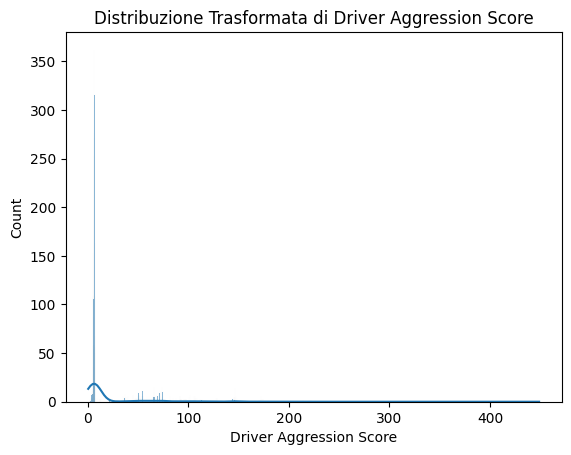

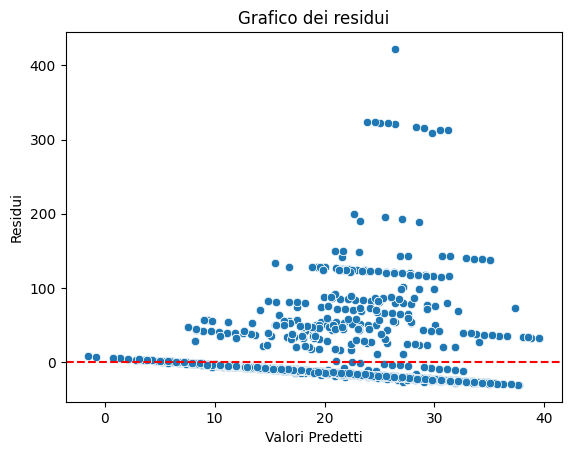

In [145]:
# 1. Seleziona le colonne numeriche (senza 'Transformed Aggression Score')
numeric_cols = ['Season','Round','Laps','Position','Wind_Speed_KMH','Temp_Humidity']

X_numeric = df[numeric_cols]

# 2. Aggiungi la colonna dell'intercetta (bias)
X_numeric = sm.add_constant(X_numeric)

# 3. Definisci la nuova variabile target trasformata
y = df['Driver Aggression Score']

# 4. Crea e adatta il modello con la variabile target trasformata
model = sm.OLS(y, X_numeric)
results = model.fit()

# 5. Stampa un riepilogo
print(results.summary())

# 6. Verifica la collinearità (VIF - Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcola il VIF per ogni variabile
vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# Stampa il VIF per ogni variabile
print("\nVIF per ogni variabile:")
print(vif_data)

# 7. Controllo della distribuzione della variabile target trasformata (istogramma)
sns.histplot(y, kde=True)
plt.title('Distribuzione Trasformata di Driver Aggression Score')
plt.show()

# 8. Verifica dei residui: grafico dei residui
residuals = results.resid
sns.scatterplot(x=results.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Grafico dei residui')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.show()

In [146]:
from sklearn.discriminant_analysis import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Normalizzazione delle variabili numeriche
numeric_cols = ['Season','Round','Laps','Position','Air_Temp_C','Humidity_%','Wind_Speed_KMH','Temp_Humidity']

# Separaro le variabili numeriche
X_numeric = df[numeric_cols]

# Normalizzo le variabili numeriche
scaler = StandardScaler()
X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# 2. Verifico della multicollinearità: Calcolare il VIF
X_vif = sm.add_constant(X_numeric_scaled)

# Calcolo del VIF per ogni variabile (Fattore di Inflazione della Varianza)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Filtro variabili con VIF > 10
print("VIF per ogni variabile:")
print(vif_data)

# Rimuovo le variabili con VIF > 10, se necessario
high_vif = vif_data[vif_data["VIF"] > 10]
print("\nVariabili con VIF alto (maggiore di 10):")
print(high_vif)

VIF per ogni variabile:
         Variable        VIF
0           const   1.000000
1          Season   1.041772
2           Round   1.287634
3            Laps   1.108760
4        Position   1.069647
5      Air_Temp_C  25.796903
6      Humidity_%  17.955852
7  Wind_Speed_KMH   1.062400
8   Temp_Humidity  37.021779

Variabili con VIF alto (maggiore di 10):
        Variable        VIF
5     Air_Temp_C  25.796903
6     Humidity_%  17.955852
8  Temp_Humidity  37.021779


Valuto l'opzione di utilizzare o solo air_temp_C e Humidity% o solo Temp_Humidity

empiricamente decido anche di usare solo Location_Time invece che time e location

                               OLS Regression Results                              
Dep. Variable:     Driver Aggression Score   R-squared:                       0.497
Model:                                 OLS   Adj. R-squared:                  0.471
Method:                      Least Squares   F-statistic:                     19.61
Date:                     Tue, 22 Apr 2025   Prob (F-statistic):          1.99e-265
Time:                             13:45:09   Log-Likelihood:                -11468.
No. Observations:                     2443   AIC:                         2.317e+04
Df Residuals:                         2325   BIC:                         2.386e+04
Df Model:                              117                                         
Covariance Type:                 nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

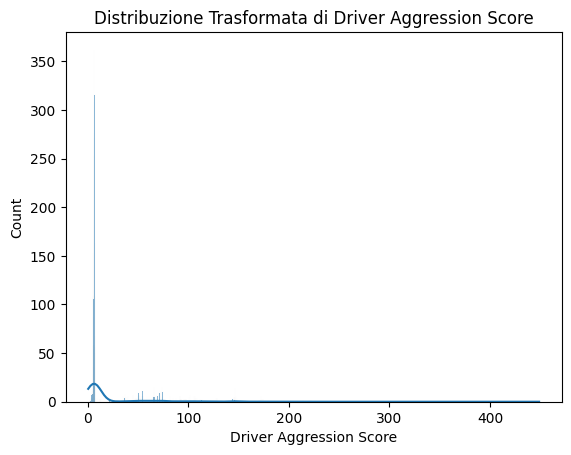

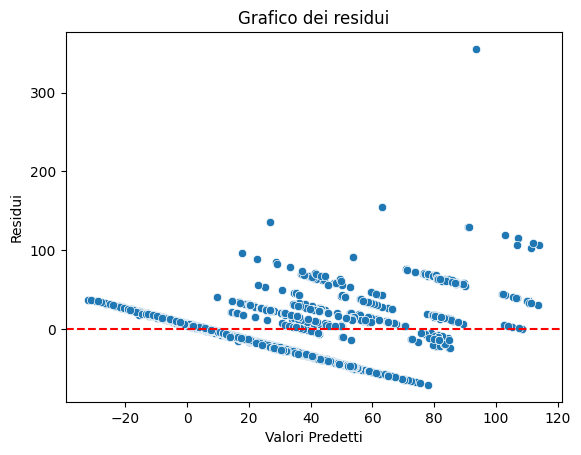

In [147]:
# Mostra tutte le righe nei print
pd.set_option('display.max_rows', None)

# === 1. Selezione delle colonne ===
numeric_cols = ['Season', 'Round', 'Laps', 'Position', 'Wind_Speed_KMH', 'Air_Temp_C', 'Humidity_%']
categorical_cols = ['Circuit', 'Constructor', 'Tire Compound', 'Constructor_Tire','Location_Time']

# === 2. Separazione delle variabili numeriche e scaling ===
X_numeric = df[numeric_cols]
scaler = StandardScaler()
X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# === 3. Codifica delle variabili categoriche ===
X_categorical = pd.get_dummies(df[categorical_cols], drop_first=True)
X_categorical = X_categorical.astype(int)  # Assicura che siano int (0 o 1)

# === 4. Costruzione del dataset finale X ===
X = pd.concat([X_numeric_scaled, X_categorical], axis=1)
X = X.apply(pd.to_numeric, errors='coerce')  # Forza tutto a numerico
X = sm.add_constant(X)  # Aggiunge l'intercetta

# === 5. Variabile target (y) ===
y = pd.to_numeric(df['Driver Aggression Score'], errors='coerce')

# === 6. Rimozione righe con NaN in X o y ===
X_y = pd.concat([X, y], axis=1)  # unisci temporaneamente per pulire insieme
X_y_clean = X_y.dropna()         # rimuovi tutte le righe con almeno un NaN

X_clean = X_y_clean.drop(columns='Driver Aggression Score')
y_clean = X_y_clean['Driver Aggression Score']

# === 7. Regressione OLS con dati puliti ===
model = sm.OLS(y_clean, X_clean)
results = model.fit()

# 5. Stampa un riepilogo
print(results.summary())

# === 9. Analisi delle variabili significative ===
significant_vars = results.pvalues[results.pvalues < 0.05]
print("\nVariabili significative (p-value < 0.05):")
print(significant_vars)

insignificant_vars = results.pvalues[results.pvalues >= 0.05]
print("\nVariabili insignificanti (p-value >= 0.05):")
print(insignificant_vars)

# 7. Controllo della distribuzione della variabile target trasformata (istogramma)
sns.histplot(y, kde=True)
plt.title('Distribuzione Trasformata di Driver Aggression Score')
plt.show()

# 8. Verifica dei residui: grafico dei residui
residuals = results.resid
sns.scatterplot(x=results.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Grafico dei residui')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.show()

📊 Valutazione del Modello
✅ R-squared: 0.727
Significa che il 72.7% della varianza nell'aggressività dei piloti è spiegata dal tuo modello.

In ambito sociale/comportamentale (come qui), un R² sopra 0.7 è già ottimo, considerando la complessità dell’essere umano.

✅ Adjusted R-squared: 0.713
Tiene conto del numero di variabili: hai 123 predittori (!).

Il fatto che l’Adjusted R² non cali troppo rispetto a R² indica che molte variabili contribuiscono realmente, oppure che il rumore non è esagerato.

✅ F-statistic: 50.29, p-value: 0.00
Questo test verifica se almeno una variabile ha effetto significativo sulla variabile target.

Il p-value ≈ 0 ti dice che il modello è globalmente significativo.

                               OLS Regression Results                              
Dep. Variable:     Driver Aggression Score   R-squared:                       0.478
Model:                                 OLS   Adj. R-squared:                  0.472
Method:                      Least Squares   F-statistic:                     78.99
Date:                     Tue, 22 Apr 2025   Prob (F-statistic):          1.76e-315
Time:                             13:45:16   Log-Likelihood:                -11513.
No. Observations:                     2443   AIC:                         2.308e+04
Df Residuals:                         2414   BIC:                         2.325e+04
Df Model:                               28                                         
Covariance Type:                 nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

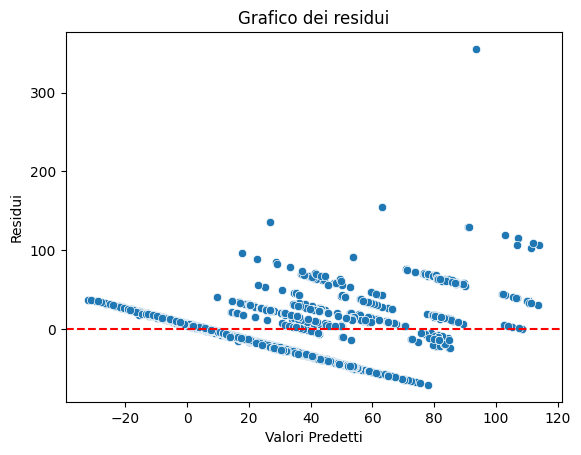

In [148]:

# 15. Rimuovo le variabili insignificanti dal DataFrame X
insignificant_cols = insignificant_vars.index
X_reduced = X.drop(columns=insignificant_cols)

# 16. Pulisco i dati da NaN o infiniti
X_reduced = X_reduced.replace([np.inf, -np.inf], np.nan).dropna()

# Allineo y alle righe rimaste in X_reduced
y_aligned = y.loc[X_reduced.index]

# 17. Riprovo a fare la regressione con il nuovo set di variabili
model_reduced = sm.OLS(y_aligned, X_reduced)
results_reduced = model_reduced.fit()

# 18. Stampo un riepilogo dei risultati del nuovo modello
print(results_reduced.summary())

# 19. Calcolo e stampo R-squared e Adjusted R-squared per il nuovo modello
r_squared_reduced = results_reduced.rsquared
adjusted_r_squared_reduced = results_reduced.rsquared_adj

print(f'R-squared (modello ridotto): {r_squared_reduced:.4f}')
print(f'Adjusted R-squared (modello ridotto): {adjusted_r_squared_reduced:.4f}')


# 8. Verifica dei residui: grafico dei residui
residuals = results.resid
sns.scatterplot(x=results.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Grafico dei residui')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.show()

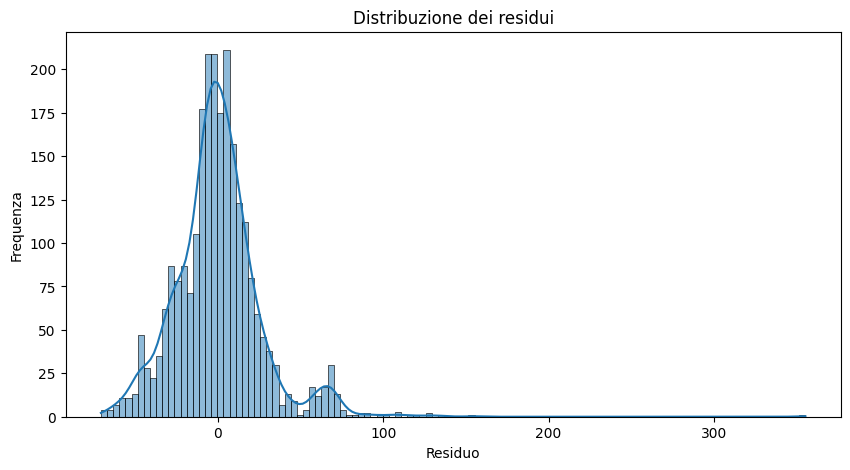

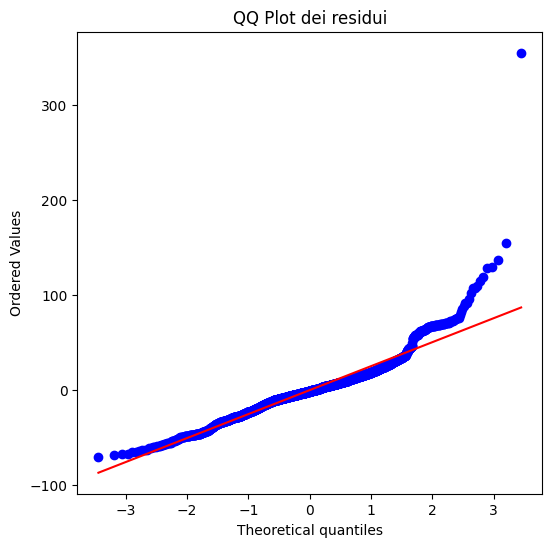

In [149]:
# Residui del modello
from scipy import stats


residuals = results.resid

# Istogramma + distribuzione normale
plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.title('Distribuzione dei residui')
plt.xlabel('Residuo')
plt.ylabel('Frequenza')
plt.show()

# QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot dei residui')
plt.show()

# Autocorrelazione dei residui

In [150]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw:.4f}')

Durbin-Watson statistic: 0.3645


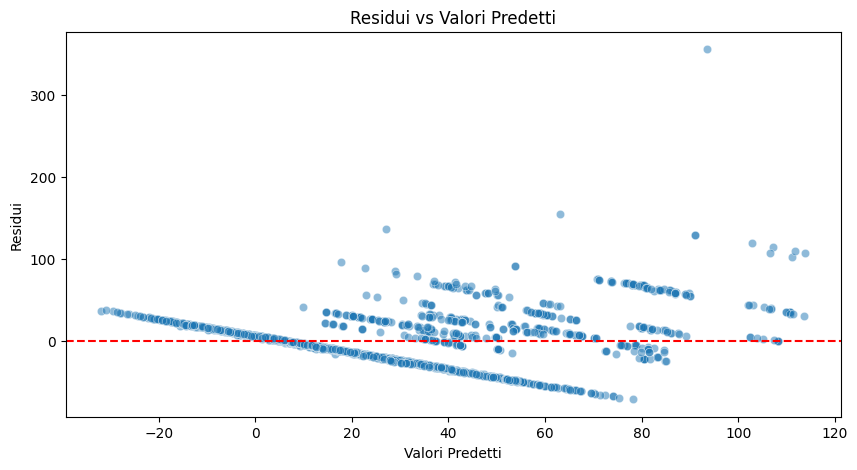

In [151]:
fitted_vals = results.fittedvalues

plt.figure(figsize=(10,5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valori Predetti')
plt.ylabel('Residui')
plt.title('Residui vs Valori Predetti')
plt.show()